In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Libraries

In [3]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split

from ast import literal_eval
# is used for safely evaluating strings containing Python literals or container displays
# (e.g., lists, dictionaries) to their corresponding Python objects.

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Load the Dataset

In [63]:
arxiv_data = pd.read_csv("/content/drive/MyDrive/RESEARCH - LSTM/file location lstm/arxiv_data.csv")

In [64]:
arxiv_data.head()

,titles,abstracts,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


Data Cleaning and Preprocessing

In [65]:
arxiv_data.shape

(51774, 3)

In [66]:
arxiv_data.isnull().sum()

,0
titles,0
abstracts,0
terms,0


In [67]:
arxiv_data.duplicated().sum()

12783

In [68]:
from ast import literal_eval

# getting unique labels
def safe_literal_eval(x):
    try:
        return literal_eval(x)
    except (ValueError, SyntaxError):
        return []  # Return an empty list if literal_eval fails

labels_column = arxiv_data['terms'].apply(safe_literal_eval) # Apply the safe_literal_eval function
labels = labels_column.explode().unique()
print("labels :", labels)
print("lenght :", len(labels))

labels : ['cs.CV' 'cs.LG' 'cs.AI' ... 'I.2.6; I.5.1; G.3'
 '92E10, 46M20, 94A08, 68U10, 44A12, 55R35' '92E10']
lenght : 1099


In [69]:
# remove duplicate entries based on the "titles" (terms) column
# This filters the DataFrame, keeping only the rows where the titles are not duplicated.
arxiv_data = arxiv_data[~arxiv_data['titles'].duplicated()]
print(f"There are {len(arxiv_data)} rows in the deduplicated dataset.")
# There are some terms with occurrence as low as 1.
print(sum(arxiv_data['terms'].value_counts()==1))
# how many unique terms
print(arxiv_data['terms'].nunique())

There are 38972 rows in the deduplicated dataset.
2321
3157


In [70]:
# Filtering the rare terms. (it keeps only those rows where the "terms" value occurs more than once in the original DataFrame.)
arxiv_data_filtered = arxiv_data.groupby('terms').filter(lambda x: len(x) > 1)
arxiv_data_filtered.shape

(36651, 3)

In [71]:
# It evaluates the given string containing a Python literal or container display (e.g., a list or dictionary) and returns the corresponding Python object.
arxiv_data_filtered['terms'] = arxiv_data_filtered['terms'].apply(lambda x: literal_eval(x))
arxiv_data_filtered['terms'].values[:3]

array([list(['cs.CV', 'cs.LG']), list(['cs.CV', 'cs.AI', 'cs.LG']),
       list(['cs.CV', 'cs.AI'])], dtype=object)

Train-Test Split

In [72]:
test_split = 0.1

# Initial train and test split.
# The stratify parameter ensures that the splitting is done in a way that preserves the same distribution of labels (terms) in both the training and test sets.
train_df, test_df = train_test_split(arxiv_data_filtered,test_size=test_split,stratify=arxiv_data_filtered["terms"].values,)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 32985
Number of rows in validation set: 1833
Number of rows in test set: 1833


In [73]:
# creates a TensorFlow RaggedTensor (terms) from the values in the "terms" column of the train_df DataFrame. A RaggedTensor is a tensor with non-uniform shapes
terms = tf.ragged.constant(train_df['terms'].values)
# This line creates a StringLookup layer in TensorFlow. The purpose of this layer is to map strings to integer indices and vice versa. The output_mode="multi_hot" indicates that the layer will output a multi-hot encoded representation of the input strings.
lookup = tf.keras.layers.StringLookup(output_mode='multi_hot')
# This step adapts the StringLookup layer to the unique values in the "terms" column, building the vocabulary.
lookup.adapt(terms)
# retrieve vocabulary
vocab = lookup.get_vocabulary()

print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'cs.CV', 'cs.LG', 'stat.ML', 'cs.AI', 'eess.IV', 'cs.RO', 'cs.CL', 'cs.NE', 'cs.CR', 'math.OC', 'eess.SP', 'cs.GR', 'cs.SI', 'cs.MM', 'cs.SY', 'cs.IR', 'cs.MA', 'eess.SY', 'cs.HC', 'math.IT', 'cs.IT', 'cs.DC', 'cs.CY', 'stat.AP', 'stat.TH', 'math.ST', 'stat.ME', 'eess.AS', 'cs.SD', 'q-bio.QM', 'q-bio.NC', 'cs.DS', 'cs.GT', 'cs.CG', 'cs.SE', 'cs.NI', 'I.2.6', 'stat.CO', 'math.NA', 'cs.NA', 'physics.chem-ph', 'cs.DB', 'q-bio.BM', 'cs.LO', 'cond-mat.dis-nn', '68T45', 'math.PR', 'cs.PL', 'physics.comp-ph', 'cs.CE', 'cs.AR', 'I.2.10', 'q-fin.ST', 'cond-mat.stat-mech', '68T05', 'quant-ph', 'math.DS', 'cs.CC', 'physics.data-an', 'I.4.6', 'physics.soc-ph', 'physics.ao-ph', 'econ.EM', 'cs.DM', 'q-bio.GN', 'physics.med-ph', 'cs.PF', 'astro-ph.IM', 'I.4.8', 'math.AT', 'cs.FL', 'I.4', 'q-fin.TR', 'I.5.4', 'I.2', '68U10', 'physics.optics', 'hep-ex', '68T10', 'physics.geo-ph', 'cond-mat.mtrl-sci', 'q-fin.CP', 'physics.flu-dyn', 'math.CO', 'math.AP', 'I.4; I.5', 'I.4.9', 'I.2.6

In [74]:
sample_label = train_df["terms"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['cs.LG', 'cs.CV', 'stat.ML']
Label-binarized representation: [[0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [75]:
# following lines::
# which is used for automatic adjustment of resource usage by TensorFlow's data loading pipeline.

#max_seqlen: Maximum sequence length. It indicates the maximum length allowed for sequences.
max_seqlen = 150
#batch_size: Batch size. It specifies the number of samples to use in each iteration.
batch_size = 128
#padding_token: A token used for padding sequences.
padding_token = "<pad>"
#auto = tf.data.AUTOTUNE: auto is assigned the value tf.data.AUTOTUNE,
auto = tf.data.AUTOTUNE

def make_dataset(dataframe, is_train=True):
    # creating sequences of labesls
    labels = tf.ragged.constant(dataframe["terms"].values)
    #This line uses the previously defined lookup layer to convert the ragged tensor of labels into a binarized representation. The resulting label_binarized is a NumPy array.
    label_binarized = lookup(labels).numpy()
    # creating sequences of text.
    dataset = tf.data.Dataset.from_tensor_slices((dataframe["abstracts"].values, label_binarized))
    # shuffling data basis on condition
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

"""
In summary, the make_dataset function is designed to create a
dataset suitable for training a model. It takes a dataframe as input,
assumes it has "abstracts" and "terms" columns, and creates a dataset of
batches where each batch consists of abstract
sequences and their corresponding binarized label sequences.
"""

'\nIn summary, the make_dataset function is designed to create a \ndataset suitable for training a model. It takes a dataframe as input, \nassumes it has "abstracts" and "terms" columns, and creates a dataset of \nbatches where each batch consists of abstract \nsequences and their corresponding binarized label sequences. \n'

In [76]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [77]:
# This function converts the multi-hot encoded labels back to their text representation
def invert_multi_hot(encoded_labels):
    """Reverse a multi-hot encoding to a list of strings."""
    # Get the indices where the encoded_labels are 1
    indices = tf.where(encoded_labels == 1).numpy().flatten()
    # Get the corresponding vocabulary terms using the indices
    return [vocab[index] for index in indices if index > 0]

# The rest of your code
text_batch, label_batch = next(iter(train_dataset))
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'Modelers use automatic differentiation (AD) of computation graphs to\nimplement complex Deep Learning models without defining gradient computations.\nStochastic AD extends AD to stochastic computation graphs with sampling steps,\nwhich arise when modelers handle the intractable expectations common in\nReinforcement Learning and Variational Inference. However, current methods for\nstochastic AD are limited: They are either only applicable to continuous random\nvariables and differentiable functions, or can only use simple but high\nvariance score-function estimators. To overcome these limitations, we introduce\nStorchastic, a new framework for AD of stochastic computation graphs.\nStorchastic allows the modeler to choose from a wide variety of gradient\nestimation methods at each sampling step, to optimally reduce the variance of\nthe gradient estimates. Furthermore, Storchastic is provably unbiased for\nestimation of any-order gradients, and generalizes variance reduction\n

In [78]:
# This code calculates the size of the vocabulary in the "abstracts" column of the train_df DataFrame.

# Creating vocabulary with uniques words
vocabulary = set()
train_df["abstracts"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

153184


Text Vectorization

In [79]:
# Initializes a TextVectorization layer
text_vectorizer = layers.TextVectorization(max_tokens=vocabulary_size,ngrams=2,output_mode="tf_idf")
# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

In [80]:
"""
Mapping Vectorization to Datasets: The code maps the text vectorization operation to
each element of the training, validation, and test datasets. This ensures that the text
data in each dataset is transformed into numerical vectors using the adapted TextVectorization layer.
The num_parallel_calls parameter is used to parallelize the mapping process, and prefetch is
applied to prefetch data batches
for better performance.
"""
train_dataset = train_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
validation_dataset = validation_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
test_dataset = test_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)

Model Training

In [81]:
# creating shallow_mlp_model  (MLP)
from tensorflow.keras.callbacks import EarlyStopping

# Creating shallow_mlp_model (MLP) with dropout layers
model1 = keras.Sequential([
    # First hidden layer: 512 neurons, ReLU activation function, with dropout.
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),  # Adding dropout for regularization.

    # Second hidden layer: 256 neurons, ReLU activation function, with dropout.
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),  # Adding dropout for regularization.

    # Output layer: The number of neurons equals the vocabulary size (output vocabulary of the StringLookup layer), with a sigmoid activation function.
    layers.Dense(lookup.vocabulary_size(), activation='sigmoid')
])

# Compile the model
model1.compile(loss="binary_crossentropy", optimizer='adam', metrics=['binary_accuracy'])

# Add early stopping
# Number of epochs with no improvement after which training will be stopped.
# Restore weights from the epoch with the best value of the monitored quantity.
early_stopping = EarlyStopping(patience=5,restore_best_weights=True)

# Train the model
# Add early stopping callback.verbose=1
history = model1.fit(train_dataset,validation_data=validation_dataset,epochs=20,callbacks=[early_stopping])

Epoch 1/20
258/258 [==============================] - 86s 329ms/step - loss: 0.0519 - binary_accuracy: 0.9819 - val_loss: 0.0190 - val_binary_accuracy: 0.9943
Epoch 2/20
258/258 [==============================] - 85s 329ms/step - loss: 0.0184 - binary_accuracy: 0.9947 - val_loss: 0.0181 - val_binary_accuracy: 0.9944
Epoch 3/20
258/258 [==============================] - 85s 330ms/step - loss: 0.0143 - binary_accuracy: 0.9957 - val_loss: 0.0191 - val_binary_accuracy: 0.9944
Epoch 4/20
258/258 [==============================] - 85s 329ms/step - loss: 0.0118 - binary_accuracy: 0.9965 - val_loss: 0.0198 - val_binary_accuracy: 0.9943
Epoch 5/20
258/258 [==============================] - 85s 330ms/step - loss: 0.0101 - binary_accuracy: 0.9970 - val_loss: 0.0197 - val_binary_accuracy: 0.9944
Epoch 6/20
258/258 [==============================] - 85s 328ms/step - loss: 0.0088 - binary_accuracy: 0.9974 - val_loss: 0.0202 - val_binary_accuracy: 0.9943
Epoch 7/20
258/258 [==========================

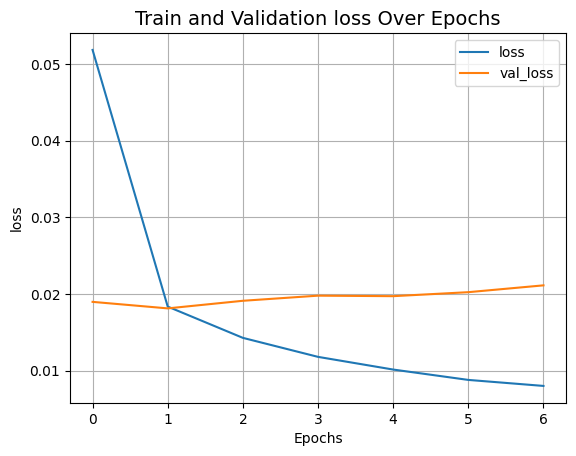

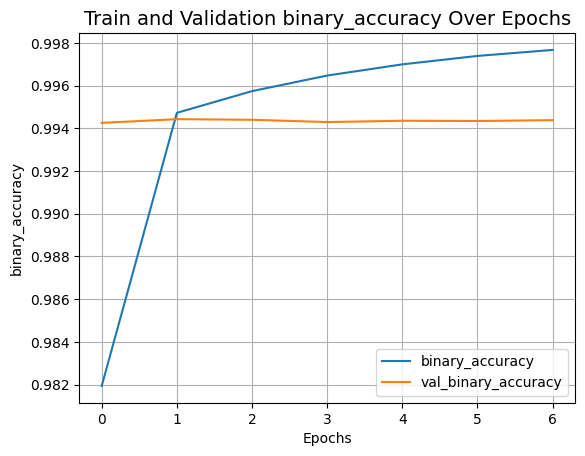

In [82]:
# plotting loss
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

Model Evaluation

In [83]:
# model evaltuation on test and val dataset
_, binary_acc1 = model1.evaluate(test_dataset)
_, binary_acc2 = model1.evaluate(validation_dataset)

print(f"Categorical accuracy on the test set: {round(binary_acc1 * 100, 2)}%.")
print(f"Categorical accuracy on the validation set: {round(binary_acc2 * 100, 2)}%.")

15/15 [==============================] - 1s 33ms/step - loss: 0.0181 - binary_accuracy: 0.9944
Categorical accuracy on the test set: 99.42%.
Categorical accuracy on the validation set: 99.44%.


Metrics

In [85]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report


In [86]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report
import numpy as np

# Assuming you already have y_test_binarized, y_pred_binary, and y_pred_prob

# Check the shapes of y_test_binarized and predictions
print(f"Shape of y_test_binarized: {y_test_binarized.shape}")
print(f"Shape of y_pred_binary: {y_pred_binary.shape}")
print(f"Shape of y_pred_prob: {y_pred_prob.shape}")

# Adjust shapes if necessary (handle shape mismatch)
if len(y_pred_binary) != len(y_test_binarized):
    print(f"Shape mismatch detected! Adjusting y_pred_binary from {len(y_pred_binary)} to {len(y_test_binarized)}")
    y_pred_binary = y_pred_binary[:len(y_test_binarized)]  # Trim to match length

if len(y_pred_prob) != len(y_test_binarized):
    print(f"Shape mismatch detected! Adjusting y_pred_prob from {len(y_pred_prob)} to {len(y_test_binarized)}")
    y_pred_prob = y_pred_prob[:len(y_test_binarized)]  # Trim to match length

# Recalculate the metrics with adjusted predictions
precision = precision_score(y_test_binarized, y_pred_binary, average='micro')
recall = recall_score(y_test_binarized, y_pred_binary, average='micro')
f1 = f1_score(y_test_binarized, y_pred_binary, average='micro')

# Calculate AUC-ROC, handle cases where only one class is present
try:
    auc_roc = roc_auc_score(y_test_binarized, y_pred_prob)
    print(f'AUC-ROC: {auc_roc:.4f}')
except ValueError as e:
    print(f"AUC-ROC cannot be calculated: {e}")

# Print Metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Optional: Print a detailed classification report
print(classification_report(y_test_binarized, y_pred_binary))


Shape of y_test_binarized: (514,)
Shape of y_pred_binary: (514,)
Shape of y_pred_prob: (514, 91)
AUC-ROC cannot be calculated: multi_class must be in ('ovo', 'ovr')
Precision: 0.9942
Recall: 0.9942
F1 Score: 0.9942
                      precision    recall  f1-score   support

-9223372036854775808       0.00      0.00      0.00         2
                   0       0.99      1.00      1.00       511
                  68       0.00      0.00      0.00         1

            accuracy                           0.99       514
           macro avg       0.33      0.33      0.33       514
        weighted avg       0.99      0.99      0.99       514



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Save Model and Text Vectorizer:

In [89]:
# Save the model
model1.save("/content/drive/MyDrive/RESEARCH - LSTM/file location lstm")

# Import the pickle module
import pickle

# Save the configuration of the text vectorizer
saved_text_vectorizer_config = text_vectorizer.get_config()
with open("/content/drive/MyDrive/RESEARCH - LSTM/file location lstm/text_vectorizer_config.pkl", "wb") as f:
    pickle.dump(saved_text_vectorizer_config, f)


# Save the vocabulary
with open("/content/drive/MyDrive/RESEARCH - LSTM/file location lstm/vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

In [90]:
# Load the vocabulary
with open("/content/drive/MyDrive/RESEARCH - LSTM/file location lstm/vocab.pkl", "rb") as f:
    loaded_vocab = pickle.load(f)